In [1]:
import matplotlib.pyplot as plt
import xtrack as xt
import scipy as sc
import bpmeth
import sympy as sp
import math
import numpy as np
from cpymad.madx import Madx
from sympy.abc import alpha, beta  # Cool notebook greek letters!
import sys
import warnings
import nafflib


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2026.01.16 14:38:06      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ==== DRIFTS =====

q_drift        = 1.05;

mb_drift       = 0.2;

mb_quad_drift  = 0.15; // space mb2q + endcoils Q

sx_drift       = 0.5;

ss_drift       =  4.;



! ==== DIPOLE GEOMETRY ====

edge          = 30./180.*pi;

ein1          := edge;  

eout1         := edge;

fint	      = 0.42;

hgap          = 0.035;



phi            = 60./180.*pi;

rho            = 2.737;

mb_len        := phi*rho;



! ==== QUADRUPOLE STRENGTHS =====

quad_len       = 0.2;

qb_len         = 0.400;

qf_len         = 0.400;

qd_len         = 0.235;

sx_len         = 0.115;



mb_k1          = -0.11; 

qb_k1          = 2.8067743015574944;

qf_k1          = 2.6880579191671385;  

qd_k1          = -2.9440570148491068;



! ===

Converting sequence "he_ring": 100%|██████████| 73/73 [00:00<00:00, 1046.65it/s]


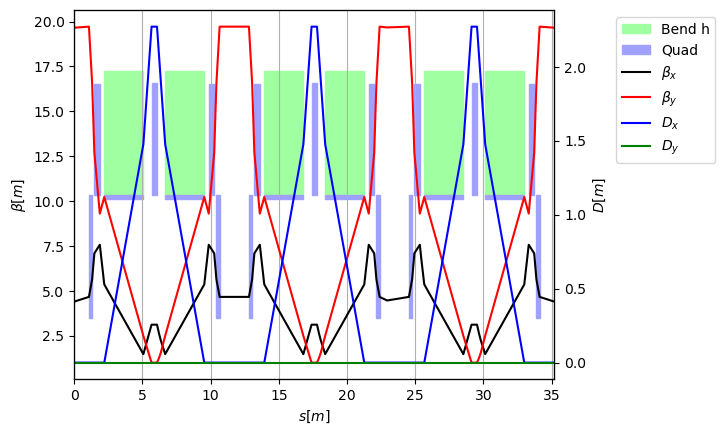

In [2]:
##################
# HeLICS lattice #
##################

mad=Madx()
mad.call("/home/silke/Documents/HeLICS/HeLICS.str")
mad.call("/home/silke/Documents/HeLICS/HeLICS.seq")
mad.beam()
mad.use("he_ring")

def match_tunes(madx,qx,qy):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    GLOBAL, Q2={qy},Q1={qx};
    vary, name=qd_k1, step=0.0000001;
    vary, name=qf_k1, step=0.0000001;
    simplex, calls=5000, tolerance=1E-10;
    endmatch;''')
    qf = madx.eval('qf_k1')
    qd = madx.eval('qd_k1')
    return qf,qd

def match_disp(madx):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    constraint, sequence=he_ring, range = "qf2b", DX=0.0;
    vary, name=qb_k1, step=0.0000001;
    jacobian, calls=5000, tolerance=1E-10;
    endmatch;''')
    qb = madx.eval('qb_k1') 
    return qb

print("Matched to Qx 2.4, Qy 1.2 with quadrupole strengths qf, qd = ", match_tunes(mad, 2.39, 1.21))

fringe="linear"

line=xt.Line.from_madx_sequence(mad.sequence.he_ring)
line.configure_bend_model(edge=fringe, core='adaptive', num_multipole_kicks=30)
line.particle_ref=xt.Particles(mass0=0.931494 * 4.001506179127e9, q0=2., energy0=(0.931494 * 4.001506179127 + 0.02)*1e9)  # Energy in eV, top energy
start_elem = "lssc"
line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
    
tw0 = line.twiss4d()
tw0.plot()

### Track particles

In [3]:
def calc_physical_coordinates(xn, yn, beta=1, alpha=0):
    """Convert normalized coordinates to physical coordinates."""
    x = xn * np.sqrt(beta) 
    px = (alpha * xn + yn) / np.sqrt(beta)
    return x, px

In [4]:
#################################################
# Distribution of particles in normalized space #
#################################################

def create_particles(nr=80, nphi=40):
    n_part = nr * nphi
    r = np.linspace(0, 0.1, nr)
    phi = np.linspace(0, np.pi/2, nphi)

    R, PHI = np.meshgrid(r, phi)
    R = R.flatten()
    PHI = PHI.flatten()

    Xn = R * np.cos(PHI)
    Yn = R * np.sin(PHI)

    # To physical space 
    X, Y = calc_physical_coordinates(Xn, Yn, beta=tw0.betx[0], alpha=tw0.alfx[0])


    part = line.build_particles(x = X, px = 0, y = Y, py = 0, zeta=0, delta=0)
    print(f"{n_part} particles created")

    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(X, Y, s=1)
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    return X, Y, part

In [5]:
def track_line(part, n_turn = 1000):
    line.track(part, num_turns=n_turn, turn_by_turn_monitor=True)
    mon = line.record_last_track
    return mon

# plot Frequency Map Analysis

In [6]:
def calc_normalized_coords(x, px, betx=1, alphx=0):
    xn = x/np.sqrt(betx)
    pxn = (x*alphx/np.sqrt(betx) + px*np.sqrt(betx))
    return xn, pxn

In [7]:
def calc_h(x, px, y, py):
    xn, pxn = calc_normalized_coords(x, px, betx=tw0.betx[0], alphx=tw0.alfx[0])
    hxm = xn - 1j*pxn

    yn, pyn = calc_normalized_coords(y, py, betx=tw0.bety[0], alphx=tw0.alfy[0])
    hym = yn - 1j*pyn
    return hxm, hym

In [13]:
def calc_tunes(hxm, hym):
    n_part = len(hxm)
    Qx1 = np.zeros(n_part)
    Qx2 = np.zeros(n_part)
    Qy1 = np.zeros(n_part)
    Qy2 = np.zeros(n_part)

    for i in range(n_part):
        Qx1[i] = nafflib.tune(hxm[:200, i], window_order=2, window_type="hann")
        Qx2[i] = nafflib.tune(hxm[-200:, i], window_order=2, window_type="hann")
        Qy1[i] = nafflib.tune(hym[:200, i], window_order=2, window_type="hann")
        Qy2[i] = nafflib.tune(hym[-200:, i], window_order=2, window_type="hann")
    return Qx1, Qx2, Qy1, Qy2

In [9]:
def tunediff(Q1, Q2):
    """ Tune described over interval [-0.5, 0.5] """
    return np.min(np.array([np.abs(Q2 - Q1), 1 - np.abs(Q2 - Q1)]), axis=0)
    

In [10]:
def save_data(filename, X, Y, Qx1, Qx2, Qy1, Qy2):
    dQ = np.log10(np.sqrt((tunediff(Qx1, Qx2))**2 + tunediff(Qy1, Qy2)**2))
    np.savetxt(filename, np.array([X, Y, Qx1, Qy1, dQ]).T, header="x [m], y [m], Qx, Qy, log10(sqrt(dQx**2 + dQy**2))")

### Save plot data

In [11]:
def calc_FMA(fringe, n_turn = 1000):
    line=xt.Line.from_madx_sequence(mad.sequence.he_ring)
    line.configure_bend_model(edge=fringe, core='adaptive', num_multipole_kicks=30)
    line.particle_ref=xt.Particles(mass0=0.931494 * 4.001506179127e9, q0=2., energy0=(0.931494 * 4.001506179127 + 0.02)*1e9)  # Energy in eV, top energy
    start_elem = "lssc"
    line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
        
    tw0 = line.twiss4d()

    X, Y, part = create_particles(nr=80, nphi=40)
    mon = track_line(part, n_turn = n_turn)
    hxm, hym = calc_h(mon.x, mon.px, mon.y, mon.py)
    Qx1, Qx2, Qy1, Qy2 = calc_tunes(hxm, hym)
    save_data(f"FMA_{fringe}fringe_{n_turn}turns.txt", X, Y, Qx1, Qx2, Qy1, Qy2)

In [12]:
calc_FMA(fringe="linear", n_turn=1000)
calc_FMA(fringe="full", n_turn=1000)

Converting sequence "he_ring": 100%|██████████| 73/73 [00:00<00:00, 724.80it/s]


3200 particles created


In [29]:
def plot_spectrum(hxm, ax):
    hfmin = np.fft.fft(hxm)
    hfminabs = np.abs(hfmin)
    hfminabs = np.fft.fftshift(hfminabs)        
    ff = np.fft.fftfreq(len(hxm))
    ff = np.fft.fftshift(ff)
    ax.plot(ff, np.log(hfminabs))

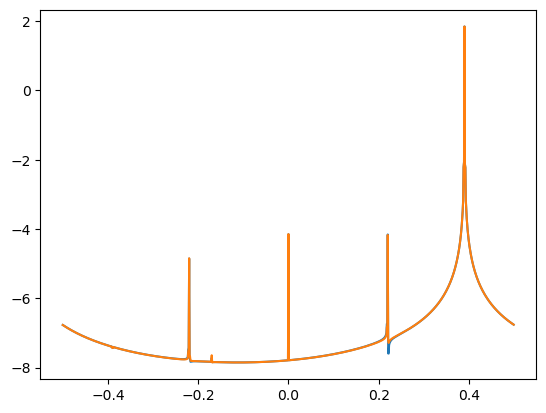

In [ ]:
fig, ax = plt.subplots()
plot_spectrum(hxm1[5], ax)
plot_spectrum(hxm2[5], ax)